In [81]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
#import seaborn as sns

In [11]:
file_list=os.listdir(path='D:/文件/学习资料/22fall/STAT 605/605project/Data/prediction')

In [56]:
df=pd.DataFrame()
for i in range(len(file_list)):
    dfi=pd.DataFrame(np.load('D:/文件/学习资料/22fall/STAT 605/605project/Data/prediction/'+file_list[i],allow_pickle=True))
    dfi.columns=['close','prediction','date']
    dfi['stock']=file_list[i][:-25]
    dfi['ret'] = dfi['prediction'].pct_change()
    df=pd.concat([df,dfi],ignore_index=True)

In [58]:
factors=df[['date','stock','ret']]

In [66]:
fall = pd.merge(factors,factors,left_on = ['stock','date'],right_on = ['stock','date'])

In [78]:
def GroupTestAllFactors_1(factors,ret,groups):
    # factors = fnorm.copy();groups = 10
    '''
    计算所有日期的因子分组IC值
    Parameters
    ----------
    factors : 数值型
        dataframe包括3列，列名分别为tradedate, stockcode和因子的名称，这里为mom.
        index为默认的index
    ret : 数值型
        dataframe包括3列，列名分别为tradedate, stockcode和ret，ret为股票收益率.
        index为默认的index
    
    groups : TYPE
        可以取数字，5或者10，代表按照quantile分成5组或者10组.

    Returns
    -------
   

    '''
    
    
    fnames = factors.columns
    fall = pd.merge(factors,ret,left_on = ['stock','date'],right_on = ['stock','date'])
    Groupret = []
    # Groupturnover = []
    
    f= fall.columns[2]
    
    fuse = fall.copy()[['stock','date','ret_x']]
    # 计算每只股票在每个日期所属的group，按照因子值从小到大等分，注意这里
    # 每组的标志分别为1，2，3，4，5
    fuse['groups'] = fuse[f].groupby(fuse.date).apply(lambda x:np.ceil(x.rank()/(len(x)/groups)))
    # 将每个日期每个group中的股票等权重构造投资组合，并计算组合收益率
    result = fuse.groupby(['date','groups']).apply(lambda x:x.ret_x.mean())
    # 构建一个透视表，使用tradedate, groups和收益率
    result = result.unstack().reset_index()
    # 构建多空投资组合
    # 如果第五组的收益高于第一组，构建高减低投资组合，保存每个日期属于第五组的股票
    if result.iloc[:,-1].mean() > result.iloc[:,-groups].mean():
        result['L-S'] = result.iloc[:,-1] - result.iloc[:,-groups]
        #stock_l = fuse.loc[fuse.groups == 1]
        stock_l = fuse.loc[fuse.groups == groups]
    else: # 如果第一组的收益高于第五组，构建低减高投资组合，保存每个日期属于第一组的股票
        result['S-L'] = result.iloc[:,-groups] - result.iloc[:,-1]
        #stock_l = fuse.loc[fuse.groups == groups]
        stock_l = fuse.loc[fuse.groups == 1]
                
    result.insert(0,'factor',f)
    Groupret.append(result)
    
    #turnovers = getturnover(stock_l)
    #turnovers.columns = [f]
    # 计算换手率
    #Groupturnover.append(turnovers)
    
    Groupret = pd.concat(Groupret,axis = 0).reset_index(drop = True)
    
    # 计算每一组的累积收益率
    Groupnav = Groupret.iloc[:,2:].groupby(Groupret.factor).apply(lambda x:(1 + x).cumprod())
    Groupnav = pd.concat([Groupret[['date','factor']],Groupnav],axis = 1)
    # 
    #Groupturnover = pd.concat(Groupturnover,axis = 1).reset_index()

    return Groupnav

C:\Users\10985\AppData\Local\Temp\ipykernel_3408\1709828095.py:34: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  fuse['groups'] = fuse[f].groupby(fuse.date).apply(lambda x:np.ceil(x.rank()/(len(x)/groups)))
C:\Users\10985\AppData\Local\Temp\ipykernel_3408\1709828095.py:61: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

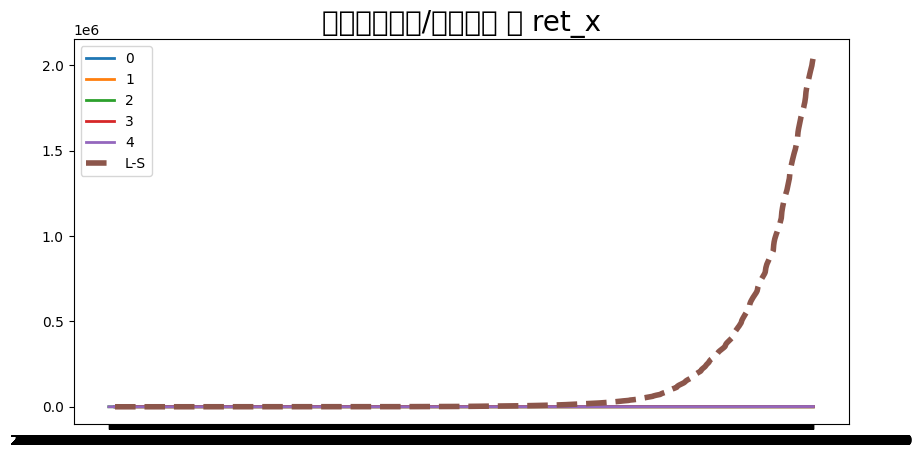

In [82]:
Groupnav= GroupTestAllFactors_1(factors,factors,5)

In [117]:
Groupnav=pd.iloc[58:,:]
f = Groupnav.factor.unique()[0]
Groupnav.date=pd.to_datetime(Groupnav.date)
fnav = Groupnav.loc[Groupnav.factor ==f,:].set_index('date').iloc[:,1:]
groups = fnav.shape[1] - 1
lwd = [2]*groups + [4]
ls = ['-']*groups + ['--']

C:\Users\10985\AppData\Local\Temp\ipykernel_3408\1695661941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Groupnav.date=pd.to_datetime(Groupnav.date)


Text(0.5, 1.0, 'Backtest for Stock Selection Strategy')

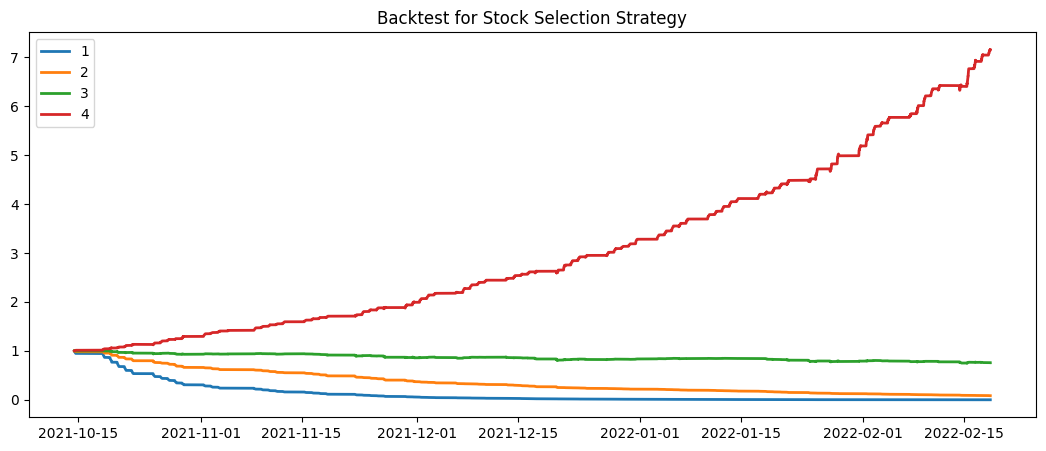

In [125]:
plt.figure(figsize = (13,5))        
for i in range(groups-1):
    plt.plot(fnav.iloc[:,i],linewidth = 2,linestyle = '-')
plt.legend([1,2,3,4])
plt.title('Backtest for Stock Selection Strategy' )